<h2> Import packages 

In [89]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [90]:
paths=[]
labels=[]
for dirname,_,filenames  in os.walk('TESS Toronto emotional speech set data'):
    for filname in filenames:
        paths.append(os.path.join(dirname,filname))
        label=filname.split('_')[-1]
        label=label.split('.')[0]
        labels.append(label.lower()) 


In [91]:
df=pd.DataFrame({'audio_paths':paths,'label':labels})

In [92]:
df.head()

,audio_paths,label
0,TESS Toronto emotional speech set data\OAF_ang...,angry
1,TESS Toronto emotional speech set data\OAF_ang...,angry
2,TESS Toronto emotional speech set data\OAF_ang...,angry
3,TESS Toronto emotional speech set data\OAF_ang...,angry
4,TESS Toronto emotional speech set data\OAF_ang...,angry


In [93]:
df['label']=df['label'].astype('category')

In [94]:
df['label'].value_counts()

label
angry      800
disgust    800
fear       800
happy      800
neutral    800
ps         800
sad        800
Name: count, dtype: int64

In [95]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

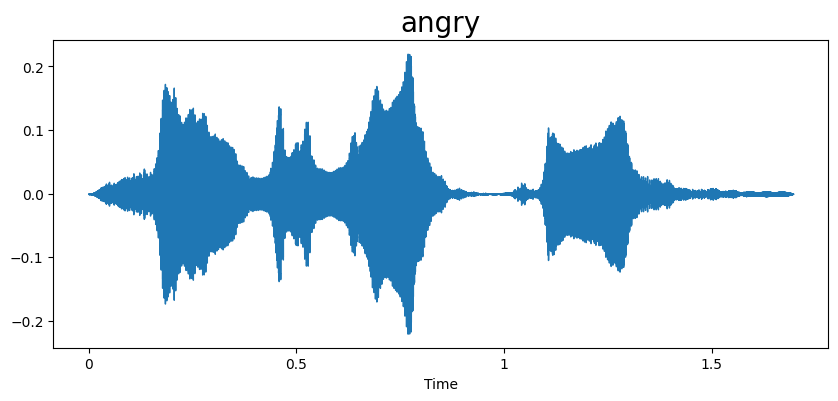

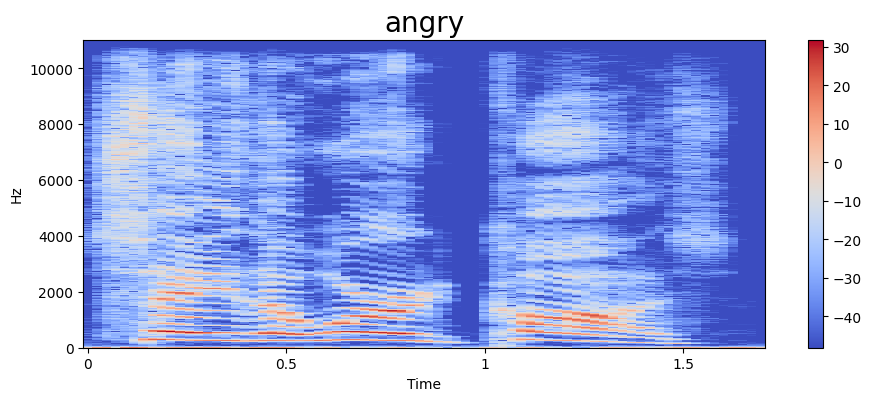

In [96]:
emotion = 'angry'
path = np.array(df['audio_paths'][df['label']==emotion])[15]
data, sampling_rate = librosa.load(path,duration=3)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

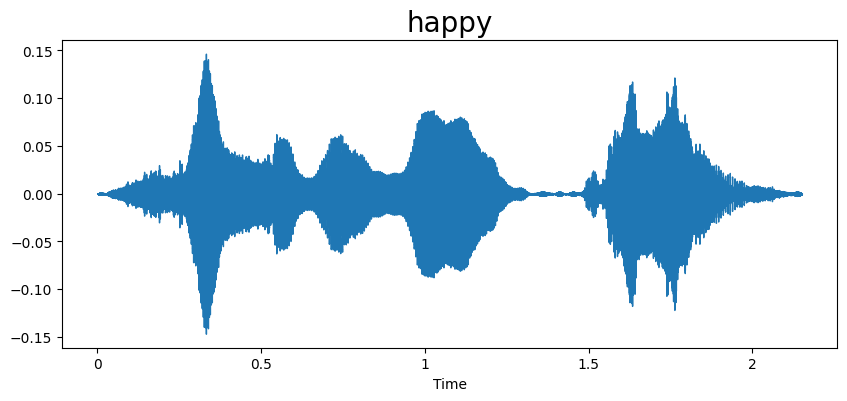

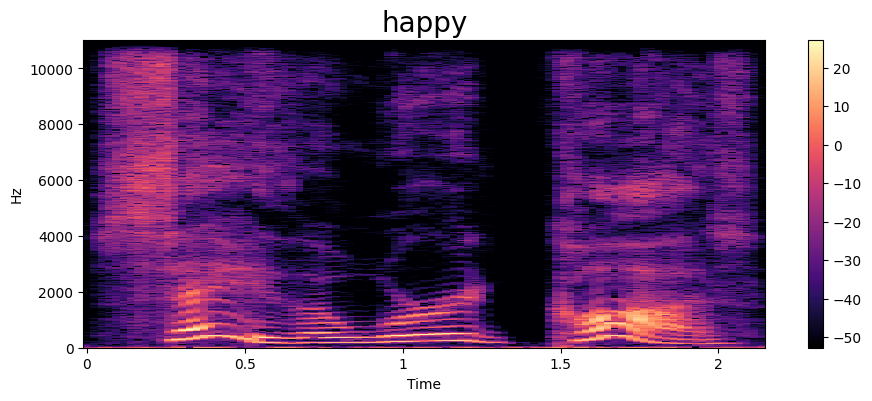

In [97]:
emotion = 'happy'
path = np.array(df['audio_paths'][df['label']==emotion])[15]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

# Feature Extraction

 <h3> MFCC is a feature extraction technique widely used in speech and audio processing. MFCCs are used to represent the spectral characteristics of sound in a way that is well-suited for various machine learning tasks, such as speech recognition and music analysis.

In [10]:
def feature_extract_mfcc(path):
    data, sampling_rate = librosa.load(path,duration=3)
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40).T, axis=0)
    return mfcc

In [36]:
feature_extract_mfcc(path)

array([-4.43359039e+02,  7.65660324e+01,  1.52313833e+01, -1.14034815e+01,
       -7.48614645e+00,  1.81936562e+00, -5.02948856e+00, -1.71122462e-01,
       -1.12168131e+01, -3.15794587e+00, -9.73934746e+00, -7.57396460e+00,
       -2.44556904e+00, -2.99430203e+00,  1.70312595e+00,  1.99820209e+00,
       -4.46350384e+00,  1.38085451e+01,  2.06752330e-01,  3.44946861e-01,
        2.72231054e+00,  2.17796773e-01, -1.59170485e+00,  4.71006680e+00,
       -2.17663908e+00,  2.13104701e+00,  7.22221315e-01,  8.27274227e+00,
        7.60823131e-01,  7.25828028e+00,  2.53323436e+00,  3.49798751e+00,
        4.47909975e+00,  4.36116552e+00,  3.61089993e+00,  8.29475689e+00,
        6.02145338e+00,  1.01156816e+01,  7.81038666e+00,  1.11974430e+01],
      dtype=float32)

In [12]:
X_features = df['audio_paths'].apply(lambda x : feature_extract_mfcc(x))

In [13]:
X_features=np.array([x for x in X_features])
X= np.expand_dims(X_features, axis=2)
X.shape

(5600, 40, 1)

In [14]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
y = enc.fit_transform(df[['label']])
y=y.toarray()
y.shape

(5600, 7)

In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(123,  input_shape=(40, 1)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 123)               61500     
                                                                 
 dense_3 (Dense)             (None, 64)                7936      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 7)                 231       
                                                                 
Total params: 71747 (280.26 KB)
Trainable params: 7174

In [19]:
history=model.fit(X, y, 
          epochs=150, 
          batch_size=512, 
          validation_split=0.2, 
          shuffle = True)

Epoch 1/150
9/9 [==============================] - 6s 282ms/step - loss: 1.8724 - accuracy: 0.2391 - val_loss: 1.8627 - val_accuracy: 0.2875
Epoch 2/150
9/9 [==============================] - 2s 211ms/step - loss: 1.6496 - accuracy: 0.4076 - val_loss: 1.6392 - val_accuracy: 0.3500
Epoch 3/150
9/9 [==============================] - 2s 187ms/step - loss: 1.3381 - accuracy: 0.5092 - val_loss: 1.2115 - val_accuracy: 0.4607
Epoch 4/150
9/9 [==============================] - 2s 184ms/step - loss: 1.0186 - accuracy: 0.6172 - val_loss: 0.8044 - val_accuracy: 0.6589
Epoch 5/150
9/9 [==============================] - 2s 184ms/step - loss: 0.6857 - accuracy: 0.7612 - val_loss: 0.4819 - val_accuracy: 0.8562
Epoch 6/150
9/9 [==============================] - 2s 181ms/step - loss: 0.4886 - accuracy: 0.8259 - val_loss: 0.2892 - val_accuracy: 0.9187
Epoch 7/150
9/9 [==============================] - 2s 180ms/step - loss: 0.3828 - accuracy: 0.8743 - val_loss: 0.2282 - val_accuracy: 0.9357
Epoch 8/150
9

In [21]:
model.save("emotion_model.h5")

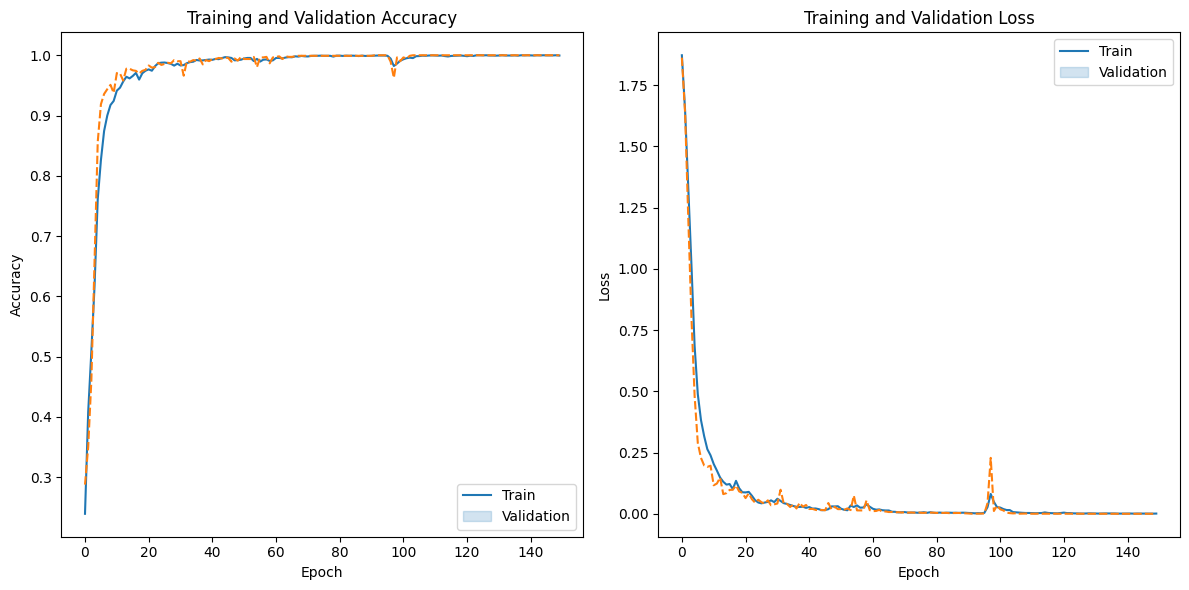

In [20]:
history_df = pd.DataFrame(history.history)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training and validation loss
plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [123]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

# Load the saved model
loaded_model = load_model('emotion_model.h5')

# Load your DataFrame containing the training data
# Replace 'your_data.csv' with the actual path to your data file

# Extract unique labels and create a mapping
unique_labels = df['label'].unique()
label_mapping = {label: i for i, label in enumerate(unique_labels)}
print("Label Mapping:", label_mapping)

# Assuming 'X_new' contains your new audio features (adjust this accordingly)
# You may need to use your feature extraction function to get 'X_new'
# Replace 'feature_extract_mfcc' with your actual feature extraction function
new_path='YAF_calm_happy.wav'
X_new = feature_extract_mfcc(new_path)
# Reshape 'X_new' to match the model input shape
X_new = np.expand_dims(X_new, axis=0)

# Make predictions
predictions = loaded_model.predict(X_new)
print(predictions)

predicted_label_indices = np.argmax(predictions, axis=1)
print("Predicted Label Indices:", predicted_label_indices)

# Display the predicted labels using the mapping
predicted_labels = [list(label_mapping.keys())[i] for i in predicted_label_indices]
print("Predicted Labels:", predicted_labels)
Audio(new_path)


Label Mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'ps': 5, 'sad': 6}
1/1 [==============================] - 1s 596ms/step
[[4.48247675e-07 1.41993405e-11 2.08739181e-09 9.99999523e-01
  6.62869336e-13 5.70199106e-08 2.90856141e-11]]
Predicted Label Indices: [3]
Predicted Labels: ['happy']
